<a href="https://colab.research.google.com/github/art-glazunov/MegaFon_RecSys_Workshop/blob/main/Part_6_2_Basic_convolutional_DSSM_recommender_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MegaFon RecSys workshop
by Artyom Glazunov

## Part 6.2. Basic convolutional DSSM recommender v1

## The plan

- ### Data loading
- ### Useful classes and methods
- ### Data preparation
- ### Training
- ### Evaluation

In [ ]:
pip install -q lightfm==1.16

In [ ]:
import random

import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix

import sklearn
from sklearn.base import TransformerMixin, BaseEstimator
from lightfm import data

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

import gc
import copy

### Data loading

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/datafest_22/data

/content/drive/MyDrive/Colab_Notebooks/datafest_22/data


In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
data_train_all = pd.read_csv("train.csv")
data_val = pd.read_csv("validation.csv")
data_test = pd.read_csv("test.csv")
cold_users_data = pd.read_csv("cold_users_data.csv")
cold_items_data = pd.read_csv("cold_items_data.csv")

In [ ]:
data_train_all.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,xvCGZ5McgEJlkYx2HNO1/CkD1CYjlA/gQL36iX8TYBY=,868uXMrBS8WwQulNX0W+vk6sJA6Hs35YNtFYceXgX/I=,radio,Radio,radio,0,255373.0,465,張震嶽,NaN,NaN,3.0,勇氣,TWA450479802,1,0,NaN,7,2013-05-14,2017-09-24
1,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=,my library,Local playlist more,local-library,1,248790.0,465,吳汶芳 (Fang Wu),吳汶芳,吳汶芳,3.0,孤獨的總和 (Accumulated Loneliness),TWA211328806,13,31,female,9,2011-04-19,2017-06-20
2,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=,my library,Local playlist more,local-library,1,178887.0,921,Noel Coward,NaN,NaN,52.0,Poor Little Rich Girl,USV291338277,5,33,female,9,2008-08-05,2017-10-06
3,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=,discover,Online playlist more,online-playlist,1,275136.0,465,田馥甄 (Hebe),楊子樸,施人誠,3.0,寂寞寂寞就好,TWD951043107,1,0,NaN,7,2011-02-25,2017-09-12
4,XIfoYUt6vkAqVDRKJRVEHkV0jsaD+fif2EqxsobpEqg=,rA+H/y66yC2qK0v926aWRFWngwJmL+IhGhJN4fBS0XM=,radio,Radio,radio,0,243983.0,465,范瑋琪 (Christine Fan),陳小霞,姚若龍,3.0,最重要的決定,TWA211125202,5,22,female,7,2013-07-29,2017-09-30


### Useful classes and methods

In [ ]:
class ColumnCategorizer(TransformerMixin, BaseEstimator):
    """Creates new categorical features using continuous columns
    
    Requires 
    - quantiles list
    - columns to transform
    - new columns names
    """
    

    def __init__(self, qs, new_columns, old_columns):
        self.qs = qs #quantile list
        self.new_columns = new_columns #columns to create
        self.old_columns = old_columns #initial continuous columns
        self.transformers = {} #transformers storage
        

    def fit(self, X, y=None):
        """Fit transformers on a part of the columns
        X - train data
        """
        
        for column in self.old_columns:
            bins = np.unique([X[column].quantile(q=q) for q in self.qs])
            labels = [f"{column}_bin_{l_edge}_{r_edge}" for (l_edge, r_edge) in zip(bins[:-1], bins[1:])]
            self.transformers[column] = sklearn.preprocessing.FunctionTransformer(
                                             pd.cut, kw_args={'bins': bins, 
                                                              'include_lowest': True,
                                                              'labels': labels, 
                                                              'retbins': False}
                                                              ) 
            self.transformers[column].fit(X[column])
        return self
    

    def transform(self, X):
        """Transform data and return Pandas DataFrame
        X - data to transform
        """
        
        data_new = X.copy()
        for column_old, column_new in zip(self.old_columns, self.new_columns):
            data_new[column_new] = self.transformers[column_old].transform(data_new[column_old]).values
        return data_new


def names_to_cats(data_to_transform, cols):
    """Transform numeric categories using names of features
    
    data_to_transform - data to transform
    cols - columns to change
    """

    data_new = data_to_transform.copy()
    for col in cols:
        data_new[col] = data_new[col].apply(lambda x: f"{col}_{x}").values
    return data_new

In [ ]:
def get_lfm_dataset_obj(data_in, 
                        cat_cols_to_change,
                        user_fe_cols,
                        item_fe_cols,
                        user_id_column,
                        item_id_column,
                        user_identity_features=True,
                        item_identity_features=True):
    """Get lightfm dataset object from initial data
    It's useful for further getting mappings 

    data_in - initial pandas DataFrame to use
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    user_identity_features - consider user id as a feature?
    item_identity_features - consider item id as a feature?
    """

    data_prep = names_to_cats(data_in, cat_cols_to_change)

    user_fe_data = data_prep[user_fe_cols].values
    item_fe_data = data_prep[item_fe_cols].values
    user_id = data_prep[user_id_column].values.ravel()
    item_id = data_prep[item_id_column].values.ravel()


    dataset = data.Dataset(user_identity_features=user_identity_features,
                           item_identity_features=item_identity_features)
    dataset.fit(users=user_id, items=item_id,
                user_features=user_fe_data.T.ravel(),
                item_features=item_fe_data.T.ravel())
    
    return dataset


def get_mappings(dataset):
    """Prepare the mappings

    dataset - lightfm dataset object
    """

    result_dict = {}
    result_dict["user_id_mapping"] = dataset.mapping()[0]
    result_dict["item_id_mapping"] = dataset.mapping()[2]
    result_dict["user_fename_intid_mapping"] = dataset._user_feature_mapping
    result_dict["item_fename_intid_mapping"] = dataset._item_feature_mapping
    return result_dict


def get_user_item_interactions(data_in, dataset,
                               user_id_column,
                               item_id_column):
    """Get users-items interaction matrix

    data_in - train data
    dataset - lightfm dataset object
    user_id_column/item_id_column - user/item id columnd
    """
    
    user_id = data_in[user_id_column].values.ravel()
    item_id = data_in[item_id_column].values.ravel()
    interactions, _ = dataset.build_interactions(((x[0], x[1]) for x \
                                                    in zip(user_id, item_id)))
    return interactions.tocsr()


def features_to_indices(df, columns, feature_to_index, unknown_id):  
    """Convert initial dataframe into sequences of indices 
    from feature_to_index vocab

    df - data to convert
    columns - columns to use
    feature_to_index - vocabulary
    unknown_id - the value in feature_to_index for unknown values
    """

    X = df[columns].values
    m = X.shape[0]   # number of examples
    max_len = X.shape[1] 
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        j = 0
        for feature in X[i]:
            # Set the (i,j)th entry of X_indices to the index of the correct token.
            try:
              X_indices[i, j] = feature_to_index[feature]
            except:
              X_indices[i, j] = feature_to_index[unknown_id]
            j = j + 1
       
    return X_indices


def get_interactions_train_id_mappings(mappings, 
                                     users_unique, 
                                     items_unique,
                                     user_id_column,
                                     item_id_column):
    """Get mappings between interactions ids 
    and ohe features ids

    mappings - mappings from lfm dataset
    users_unique - unique users features DataFrame (WITH id column)
    items_unique - unique items features DataFrame (WITH id column)
    user_id_column - user id column name
    item_id_column - item id column name
    """
    
    result_dict = {}

    users_iid_eid_mapping = {value: key for key, value in mappings["user_id_mapping"].items()}
    items_iid_eid_mapping = {value: key for key, value in mappings["item_id_mapping"].items()}

    users_eid_train_id_mapping = {value: key for key, value in users_unique[user_id_column].to_dict().items()}
    items_eid_train_id_mapping = {value: key for key, value in items_unique[item_id_column].to_dict().items()}

    result_dict["users_iid_train_id_mapping"] = {key: users_eid_train_id_mapping[value] \
                                              for key, value in users_iid_eid_mapping.items()}
    result_dict["items_iid_train_id_mapping"] = {key: items_eid_train_id_mapping[value] \
                                              for key, value in items_iid_eid_mapping.items()}
    
    return result_dict

### Data preparation

In [ ]:
user_fe_cols = ["city", "gender", "bd"]
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = "msno"
item_id_column = "song_id"

#Other lists of features
cat_cols_to_change = ["genre_ids", "language", "city"] #columns to add name to value
numeric_cols = ["bd"] #this columns will be categorized

#Columns in the result dataframe
result_cols = [user_id_column, item_id_column, "target"]

In [ ]:
#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=['bd'], old_columns=['bd'],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

Numeric features preparation

In [ ]:
data_train_fin = categorizer.transform(data_train_all)
data_test_fin = categorizer.transform(data_test)
data_val_fin = categorizer.transform(data_val)
cold_users_data_fin = categorizer.transform(cold_users_data)
cold_items_data_fin = categorizer.transform(cold_items_data)
data_train_all.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,xvCGZ5McgEJlkYx2HNO1/CkD1CYjlA/gQL36iX8TYBY=,868uXMrBS8WwQulNX0W+vk6sJA6Hs35YNtFYceXgX/I=,radio,Radio,radio,0,255373.0,465,張震嶽,NaN,NaN,3.0,勇氣,TWA450479802,1,0,NaN,7,2013-05-14,2017-09-24
1,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=,my library,Local playlist more,local-library,1,248790.0,465,吳汶芳 (Fang Wu),吳汶芳,吳汶芳,3.0,孤獨的總和 (Accumulated Loneliness),TWA211328806,13,31,female,9,2011-04-19,2017-06-20
2,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=,my library,Local playlist more,local-library,1,178887.0,921,Noel Coward,NaN,NaN,52.0,Poor Little Rich Girl,USV291338277,5,33,female,9,2008-08-05,2017-10-06
3,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=,discover,Online playlist more,online-playlist,1,275136.0,465,田馥甄 (Hebe),楊子樸,施人誠,3.0,寂寞寂寞就好,TWD951043107,1,0,NaN,7,2011-02-25,2017-09-12
4,XIfoYUt6vkAqVDRKJRVEHkV0jsaD+fif2EqxsobpEqg=,rA+H/y66yC2qK0v926aWRFWngwJmL+IhGhJN4fBS0XM=,radio,Radio,radio,0,243983.0,465,范瑋琪 (Christine Fan),陳小霞,姚若龍,3.0,最重要的決定,TWA211125202,5,22,female,7,2013-07-29,2017-09-30


Get interactions matrix and prepare train categorical columns

In [ ]:
lfm_dataset = get_lfm_dataset_obj(data_train_fin[data_train_fin.target==1], 
                                  cat_cols_to_change,
                                  user_fe_cols,
                                  item_fe_cols,
                                  user_id_column,
                                  item_id_column,
                                  user_identity_features=True,
                                  item_identity_features=False)

In [ ]:
interactions = get_user_item_interactions(data_train_fin[data_train_fin.target==1], lfm_dataset,
                                          user_id_column,
                                          item_id_column)
interactions

<24035x180541 sparse matrix of type '<class 'numpy.int32'>'
	with 2539875 stored elements in Compressed Sparse Row format>

In [ ]:
mappings = get_mappings(lfm_dataset)
len(mappings["user_fename_intid_mapping"]), len(mappings["item_fename_intid_mapping"])

(24067, 64079)

In [ ]:
data_train_prep = names_to_cats(data_train_fin[data_train_fin.target==1], cols=cat_cols_to_change)
users_unique = data_train_prep[user_fe_cols + [user_id_column]].drop_duplicates().reset_index(drop=True)
items_unique = data_train_prep[item_fe_cols + [item_id_column]].drop_duplicates().reset_index(drop=True)
items_unique.head()

,genre_ids,artist_name,composer,language,song_id
0,genre_ids_465,吳汶芳 (Fang Wu),吳汶芳,language_3.0,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=
1,genre_ids_921,Noel Coward,NaN,language_52.0,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=
2,genre_ids_465,田馥甄 (Hebe),楊子樸,language_3.0,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=
3,genre_ids_139|125|109,Al Green,Al Green,language_52.0,XywiBSwrlFPkeg1pNJcH99AxP8loYVD8Twr+WrjjqxM=
4,genre_ids_444,Girls' Generation (少女時代),Cho Yun Kyoung| Kim Hee Jung| Harvey Mason Jr....,language_31.0,yiaUAbtf5E8J/aLzeDe3V/zT/sXzbZiIE3m/JvEB1jI=


Augment the mappings with the unknown tokens patches

In [ ]:
users_f2i = copy.deepcopy(mappings["user_fename_intid_mapping"])
users_f2i["USER_UNKN"] = len(mappings["user_fename_intid_mapping"])
items_f2i = copy.deepcopy(mappings["item_fename_intid_mapping"])
items_f2i["ITEM_UNKN"] = len(mappings["item_fename_intid_mapping"])

Get mappings for the batch generation

In [ ]:
interactions_train_id_mappings = get_interactions_train_id_mappings(mappings, 
                                                                    users_unique, 
                                                                    items_unique,
                                                                    user_id_column,
                                                                    item_id_column)
users_iid_train_id_mapping = interactions_train_id_mappings['users_iid_train_id_mapping']
items_iid_train_id_mapping = interactions_train_id_mappings['items_iid_train_id_mapping']
len(users_iid_train_id_mapping), len(items_iid_train_id_mapping)

(24035, 180541)

### Get matrices with ids - our final model inputs

In [ ]:
users_feats_ids = features_to_indices(users_unique, user_fe_cols+[user_id_column],
                                feature_to_index=users_f2i, 
                                unknown_id="USER_UNKN")
items_feats_ids = features_to_indices(items_unique, item_fe_cols,
                                feature_to_index=items_f2i,
                                unknown_id="ITEM_UNKN")
users_feats_ids

array([[2.4035e+04, 2.4056e+04, 2.4059e+04, 0.0000e+00],
       [2.4036e+04, 2.4056e+04, 2.4059e+04, 1.0000e+00],
       [2.4037e+04, 2.4057e+04, 2.4060e+04, 2.0000e+00],
       ...,
       [2.4037e+04, 2.4057e+04, 2.4060e+04, 2.4032e+04],
       [2.4037e+04, 2.4057e+04, 2.4060e+04, 2.4033e+04],
       [2.4037e+04, 2.4057e+04, 2.4060e+04, 2.4034e+04]])

In [ ]:
del data_train_all, data_train_prep, data_train_fin
gc.collect()

203

### Training

First of all, choose embeddings size

In [ ]:
####
EMBEDDINGS_DIM = 200
####

Then, initialize the loss function and  the batch generator (here are some changes for the previous lesson) 

In [ ]:
def triplet_loss(y_true, y_pred, n=EMBEDDINGS_DIM, alpha=0.5):
    """Basic triplet loss implementation, 
    input params and their order should fit the keras loss interface

    y_true- keras interface param, only a patch for correct work
    y_pred - keras interface param, concatenated vector
    n - embedding dim size
    alpha - training parameter
    """

    input_vec = y_pred
    anchor = input_vec[:, 0 : n]
    positive = input_vec[:, n : 2*n]
    negative = input_vec[:, 2*n : 3*n]

    p_dist = K.sum(K.square(anchor - positive), axis=1)
    n_dist = K.sum(K.square(anchor - negative), axis=1)

    loss = K.maximum(p_dist - n_dist + alpha, 0.0)
 
    return loss

In [ ]:
def batch_generator_v2(items, users, 
                      interactions, 
                      users_iid_train_id_mapping,
                      items_iid_train_id_mapping,
                      batch_size=512):
  
    """Batch generator method (version for cnn models)
    The function randomly chooses the user id, positive and negative items ids
    "batch_size" times

    items - items features
    users - users features
    interactions - users-items sparse interactions matrix
    users_iid_train_id_mapping/items_iid_train_id_mapping - interaction matrix ids 
          -> features ids mappings 
    batch_size - the numbers of triplets in a batch
    """


    while True:
        uid_features = []
        pos = []
        neg = []
        uid_sample = random.sample(list(range(0, interactions.shape[0] - 1)), batch_size)
        user_sample_interactions = interactions[uid_sample].toarray()
        prob_dists = user_sample_interactions / np.sum(user_sample_interactions, axis=1, keepdims=True)
        pos_i_sample = []
        for i in range(batch_size):
            pos_i_sample.append(np.random.choice(range(interactions.shape[1]), p=prob_dists[i]))         
        neg_i_sample = random.choices(range(interactions.shape[1]), k=batch_size)

        user_oheid_sample = []
        pos_i_oheid_sample = []
        neg_i_oheid_sample = []
        for i in range(batch_size):
            user_oheid_sample.append(users_iid_train_id_mapping[uid_sample[i]])
            pos_i_oheid_sample.append(items_iid_train_id_mapping[pos_i_sample[i]])
            neg_i_oheid_sample.append(items_iid_train_id_mapping[neg_i_sample[i]])
        
        #users features
        uid_features.extend(users[user_oheid_sample])
        #items features
        pos.extend(items[pos_i_oheid_sample])
        neg.extend(items[neg_i_oheid_sample])
        
        gc.collect()
            
        yield [np.array(uid_features), np.array(pos), np.array(neg)], [np.zeros((batch_size, 1))]

#### Check out how the generator works

In [ ]:
generator_ex = batch_generator_v2(items=items_feats_ids, 
                                  users=users_feats_ids, 
                                  interactions=interactions,
                                  users_iid_train_id_mapping=users_iid_train_id_mapping,
                                  items_iid_train_id_mapping=items_iid_train_id_mapping)

result = next(generator_ex)


print(f"Users batch shape: {result[0][0].shape}")
print(f"Positive items batch shape: {result[0][1].shape}")
print(f"Negative items batch shape: {result[0][2].shape}")
print()
print(f"Patch to fit the keras interface: {result[1][0].shape}")

Users batch shape: (512, 4)
Positive items batch shape: (512, 4)
Negative items batch shape: (512, 4)

Patch to fit the keras interface: (512, 1)


### Initialize our simple dssm model graph

Here, we'll use 1D convolutional and pooling layers. If you have no experience with such networks, don't worry. Here, are some great links to research :)
- https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1
- https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610
- https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/#:~:text=Pooling%20layers%20are%20used%20to,generated%20by%20a%20convolution%20layer.

Some input params

In [ ]:
####
#internal embeddings layer dim size (not the resulting embeddings)
INT_EMB_DIM = 300
#Conv layers params
conv_sc_param = 3
kernel_size = 2
#Pooling param
pool_size = 2
####

USER_INPUT_SHAPE = (users_feats_ids.shape[1], )
USER_VOCAB_LEN = len(users_f2i)
ITEM_INPUT_SHAPE = (items_feats_ids.shape[1], )
ITEM_VOCAB_LEN = len(items_f2i)

Our architecture is pretty simple here. For example, the user model:

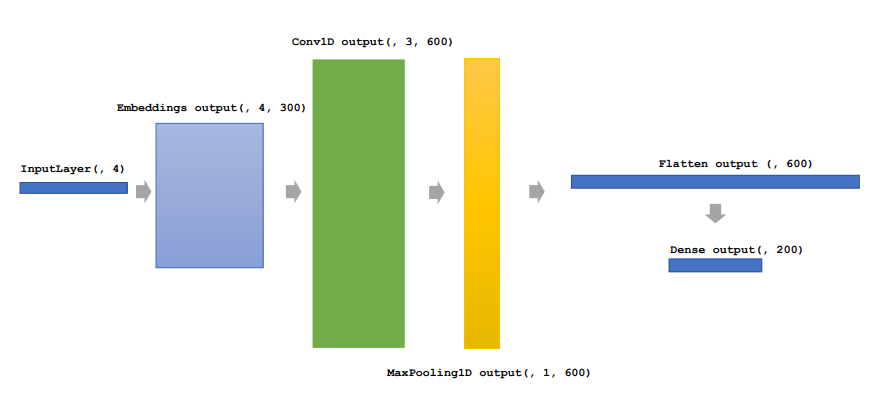

In [ ]:
# User model
u2v = keras.Sequential(
    [
        keras.layers.Input(shape=USER_INPUT_SHAPE, name="u2v_input", dtype='int32'),
        keras.layers.Embedding(input_dim=USER_VOCAB_LEN, output_dim=INT_EMB_DIM, name="u2v_embeddings"),
        keras.layers.Conv1D(conv_sc_param * EMBEDDINGS_DIM, kernel_size, activation='relu', name="u2v_conv_layer"),
        keras.layers.MaxPooling1D(pool_size, name="u2v_pooling_layer"),
        keras.layers.Flatten(name="u2v_reshape"),
        keras.layers.Dense(EMBEDDINGS_DIM, activation='linear', name="u2v_output_layer")
    ],
    name="u2v_model"
)
# Item model
i2v = keras.Sequential(
    [
        keras.layers.Input(shape=ITEM_INPUT_SHAPE, name="i2v_input", dtype='int32'),
        keras.layers.Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=INT_EMB_DIM, name="i2v_embeddings"),
        keras.layers.Conv1D(conv_sc_param * EMBEDDINGS_DIM, kernel_size, activation='relu', name="i2v_conv_layer"),
        keras.layers.MaxPooling1D(pool_size, name="i2v_pooling_layer"),
        keras.layers.Flatten(name="i2v_reshape"),
        keras.layers.Dense(EMBEDDINGS_DIM, activation='linear', name="i2v_output_layer")
    ],
    name="i2v_model"
)

ancor_inp = keras.layers.Input(shape=USER_INPUT_SHAPE)
pos_inp = keras.layers.Input(shape=ITEM_INPUT_SHAPE)
neg_inp = keras.layers.Input(shape=ITEM_INPUT_SHAPE)
ancor = u2v(ancor_inp)
positive = i2v(pos_inp)
negative = i2v(neg_inp)
merged_vecs = keras.layers.Concatenate(name="anc_pos_neg_concat")([ancor, positive, negative])
model = keras.models.Model([ancor_inp, pos_inp, neg_inp], merged_vecs, name="my_model")

### Define the optimizer, some callbacks and compile our model

In [ ]:
name = 'dssm_cnn_basic'
optimizer = keras.optimizers.Adam(learning_rate=0.001)

lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=1, factor=0.7, verbose=1)
saving = keras.callbacks.ModelCheckpoint(filepath="../models/" + name + '/best_model.h5', monitor="loss")

model.compile(loss=triplet_loss, optimizer=optimizer)

In [ ]:
model.summary()

Model: "my_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 u2v_model (Sequential)         (None, 200)          7701200     ['input_1[0][0]']                
                                                                                           

Look at the total number of parameters, it is much less than in the previous architecture. Thanks to our conv layers!:)

In [ ]:
i2v.summary()

Model: "i2v_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i2v_embeddings (Embedding)  (None, 4, 300)            19224000  
                                                                 
 i2v_conv_layer (Conv1D)     (None, 3, 600)            360600    
                                                                 
 i2v_pooling_layer (MaxPooli  (None, 1, 600)           0         
 ng1D)                                                           
                                                                 
 i2v_reshape (Flatten)       (None, 600)               0         
                                                                 
 i2v_output_layer (Dense)    (None, 200)               120200    
                                                                 
Total params: 19,704,800
Trainable params: 19,704,800
Non-trainable params: 0
_____________________________________________

In [ ]:
u2v.summary()

Model: "u2v_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 u2v_embeddings (Embedding)  (None, 4, 300)            7220400   
                                                                 
 u2v_conv_layer (Conv1D)     (None, 3, 600)            360600    
                                                                 
 u2v_pooling_layer (MaxPooli  (None, 1, 600)           0         
 ng1D)                                                           
                                                                 
 u2v_reshape (Flatten)       (None, 600)               0         
                                                                 
 u2v_output_layer (Dense)    (None, 200)               120200    
                                                                 
Total params: 7,701,200
Trainable params: 7,701,200
Non-trainable params: 0
_______________________________________________

In [ ]:
model.fit(batch_generator_v2(items=items_feats_ids, 
                            users=users_feats_ids, 
                            interactions=interactions,
                            users_iid_train_id_mapping=users_iid_train_id_mapping,
                            items_iid_train_id_mapping=items_iid_train_id_mapping,
                            batch_size=512), 
          steps_per_epoch=20, 
          epochs=15, 
          initial_epoch=0,
          callbacks=[lr_reduce, saving]
        )

Epoch 1/15
20/20 [==============================] - 257s 13s/step - loss: 0.2639 - lr: 0.0010
Epoch 2/15
20/20 [==============================] - 262s 13s/step - loss: 0.1764 - lr: 0.0010
Epoch 3/15
20/20 [==============================] - 262s 13s/step - loss: 0.1673 - lr: 0.0010
Epoch 4/15
20/20 [==============================] - 271s 14s/step - loss: 0.1480 - lr: 0.0010
Epoch 5/15
20/20 [==============================] - 262s 13s/step - loss: 0.1429 - lr: 0.0010
Epoch 6/15
20/20 [==============================] - 272s 14s/step - loss: 0.1400 - lr: 0.0010
Epoch 7/15
20/20 [==============================] - ETA: 0s - loss: 0.1400 
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
20/20 [==============================] - 267s 13s/step - loss: 0.1400 - lr: 0.0010
Epoch 8/15
20/20 [==============================] - 273s 14s/step - loss: 0.1387 - lr: 7.0000e-04
Epoch 9/15
20/20 [==============================] - 269s 13s/step - loss: 0.1343 - lr: 7.0000e-04
Epoch

### Evaluation

#### Useful evaluation methods

In [ ]:
def get_result_df(data_val, result_cols, scores):
    """Get resulting dataframe

    data_val - initial data with features
    result_cols - columns without scores (ids, other useful info)
    scores - predicted scores
    """
    
    real_pred_df = data_val[result_cols].copy()
    real_pred_df['score'] = scores
    return real_pred_df


def users_roc_auc_scores(real_pred_data, id_col="msno", 
                         target_col="target", score_col="score"):
    """Compute ROC AUC scores
    for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    roc_auc_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        roc_auc_scores.append(roc_auc_score(data_us[target_col], data_us[score_col]))
    return roc_auc_scores


def users_rr_scores(real_pred_data, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute RR scores for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    rr_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)\
                                .reset_index(drop=True)
        rr_score = 1 / ((data_us_sorted.target == 1).argmax() + 1)
        rr_scores.append(rr_score)
    return rr_scores


def precision_at_k(real_pred_data, k=5, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute precision@k scores for users

    real_pred_data - data with target and score
    k - size of the top 
    id_col- user_id column
    target_col, score_col - columns with target values and model's scores
    """

    precision_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)
        precision_score = data_us_sorted.iloc[:k].target.sum() / k
        precision_scores.append(precision_score)
    return precision_scores


def test_data_preprocessing(data_test, id="msno", k=10, 
                            min_prop=0.05, max_prop=0.95):
    """Pick only users 
    with both positive and negative responces

    data_test - data to transform
    id - user id column name
    k - minimum number of songs that a user interacted with
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """

    data_new = data_test.copy()
    val_users = []
    for user_id, data_us in data_new.groupby([id]):
        pos_cnt = data_us.target.sum()
        cnt = data_us.shape[0]
        pos_prop = pos_cnt / cnt
        if cnt >= k and pos_prop > min_prop and pos_prop < max_prop:
            val_users.append(user_id)    

    data_prep = data_new[data_new[id].isin(val_users)].reset_index(drop=True)
    return data_prep


def dssm_evaluation_v2(i2v,u2v, data_test,
                      cat_cols_to_change,
                      users_f2i,
                      items_f2i,
                      result_cols,
                      user_fe_cols,
                      item_fe_cols,
                      user_id_column,
                      batch_size=512,
                      n=100, k=5,
                      min_prop=0.25, max_prop=0.75):
    """DSSM model evaluation (version for cnn and WITHOUT item id feature)

    u2v/i2v - user/item models
    data_test - test dataframe (initial dataframe with ALL the columns, 
        the needed features will be selected via the mappings and columns sets)
    cat_cols_to_change - columns to change via names_to_cats() method
    users_f2i/items_f2i - mappings from get_mappings() method, augmented with the
        USER_UNKN/ITEN_UNKN keys
    result_cols - columns in the resulting dataframe (without score column)
    user_fe_cols/item_fe_cols - user/item feature columns
    user_id_column - user id column
    batch_size - the size of chunk for the models processing
    n - test_data_preprocessing() parameter (the min size of user's history)
    k - precision_at_k() method parameter
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """


    data_select = test_data_preprocessing(data_test, id=user_id_column, k=n,
                                          min_prop=min_prop, max_prop=max_prop)
    data_test_prep = names_to_cats(data_select, cols=cat_cols_to_change)
    users_ids = features_to_indices(data_test_prep, user_fe_cols+[user_id_column],
                                  feature_to_index=users_f2i,
                                  unknown_id="USER_UNKN")
    items_ids = features_to_indices(data_test_prep, item_fe_cols,
                                  feature_to_index=items_f2i,
                                  unknown_id="ITEM_UNKN")

    data_size = data_test_prep.shape[0]
    start = 0
    stop = batch_size
    rows_left = data_size
    sims = []
    while rows_left > 0:
        users_feats = users_ids[start:stop]
        items_feats = items_ids[start:stop]
        users_vecs = u2v.predict(users_feats)
        items_vecs = i2v.predict(items_feats)
        dists = np.linalg.norm(users_vecs - items_vecs, axis=1)
        sims.extend(1 / dists)
        
        start += batch_size
        stop += batch_size
        rows_left -= batch_size
        gc.collect()

    test_real_pred = get_result_df(data_test_prep, result_cols, sims)
    roc_auc_scores = users_roc_auc_scores(test_real_pred)
    rr_scores = users_rr_scores(test_real_pred)
    p_at_k_scores = precision_at_k(test_real_pred, k=k)
    print(f"Users mean AUC ROC on test: {np.mean(roc_auc_scores)}")
    print(f"Users mean reciprocal rank on test: {np.mean(rr_scores)}")
    print(f"Users mean precision@{k} on test: {np.mean(p_at_k_scores)}")
    plt.figure()
    plt.hist(roc_auc_scores)
    plt.title("USERS AUC ROC SCORES")
    plt.grid()
    plt.figure()
    plt.hist(rr_scores)
    plt.title(f"USERS RECIPROCAL RANK SCORES")
    plt.grid()
    plt.figure()
    plt.hist(p_at_k_scores)
    plt.title(f"USERS PRECISION@{k} SCORES")
    plt.grid()
    return test_real_pred

### So, let's evaluate our model on different sets

Users mean AUC ROC on test: 0.5919630965126753
Users mean reciprocal rank on test: 0.8317089932816936
Users mean precision@5 on test: 0.6845697329376854


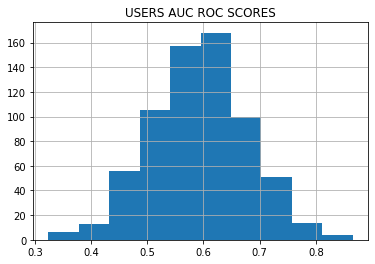

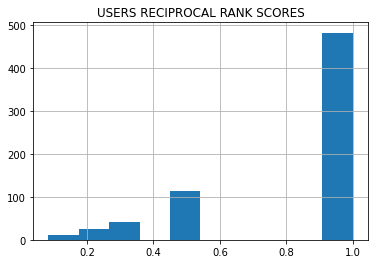

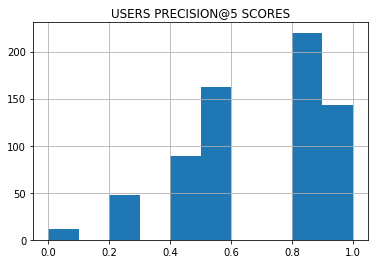

In [ ]:
val_real_pred = dssm_evaluation_v2(i2v, u2v, data_val_fin,
                                  cat_cols_to_change, 
                                  users_f2i,
                                  items_f2i,
                                  result_cols,
                                  user_fe_cols,
                                  item_fe_cols,
                                  user_id_column,
                                  batch_size=300000,
                                  n=100, k=5,
                                  min_prop=0.25, max_prop=0.75)

In [ ]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,0.717162
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,0.754188
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,0.766304
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,1.039077
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,0.961444


Users mean AUC ROC on test: 0.5913024267620243
Users mean reciprocal rank on test: 0.8368059964726632
Users mean precision@5 on test: 0.693037037037037


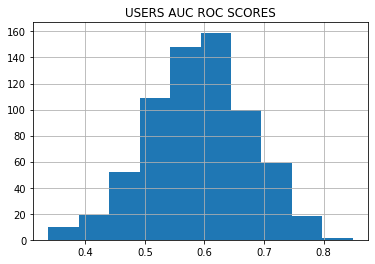

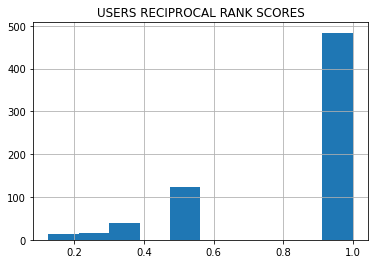

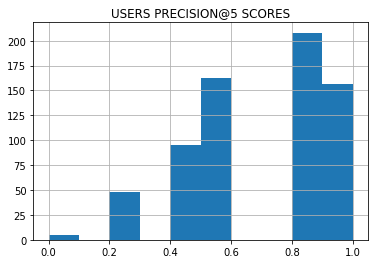

In [ ]:
_ = dssm_evaluation_v2(i2v, u2v, data_test_fin,
                      cat_cols_to_change, 
                      users_f2i,
                      items_f2i,
                      result_cols,
                      user_fe_cols,
                      item_fe_cols,
                      user_id_column,
                      batch_size=300000,
                      n=100, k=5,
                      min_prop=0.25, max_prop=0.75)

Users mean AUC ROC on test: 0.5838243495793533
Users mean reciprocal rank on test: 0.8074591477072393
Users mean precision@5 on test: 0.6569465648854962


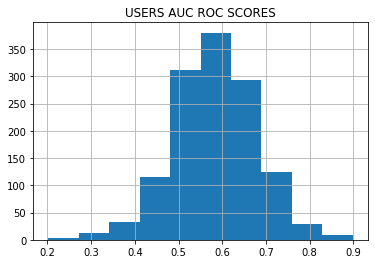

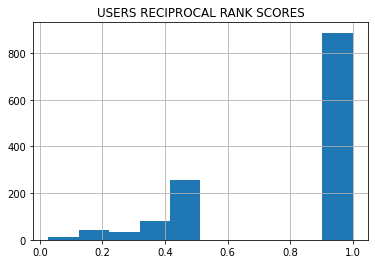

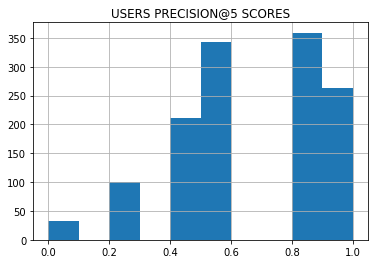

In [ ]:
_ = dssm_evaluation_v2(i2v, u2v, cold_users_data_fin,
                        cat_cols_to_change, 
                        users_f2i,
                        items_f2i,
                        result_cols,
                        user_fe_cols,
                        item_fe_cols,
                        user_id_column,
                        batch_size=300000,
                        n=100, k=5,
                        min_prop=0.25, max_prop=0.75)

Users mean AUC ROC on test: 0.5797432377794919
Users mean reciprocal rank on test: 0.7481638721216185
Users mean precision@5 on test: 0.6225352112676056


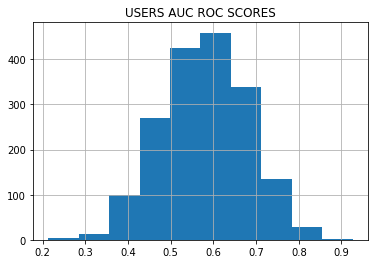

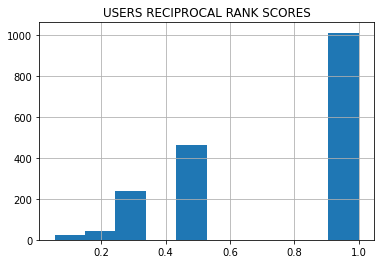

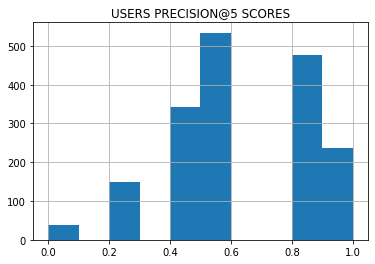

In [ ]:
_ = dssm_evaluation_v2(i2v, u2v, cold_items_data_fin,
                      cat_cols_to_change, 
                      users_f2i,
                      items_f2i,
                      result_cols,
                      user_fe_cols,
                      item_fe_cols,
                      user_id_column,
                      batch_size=300000,
                      n=40, k=5,
                      min_prop=0.25, max_prop=0.75)

### With more complex architecture we have better results, but Light FM model still outperforms our DSSM. There is some space for experimentation! :)

### Stay tuned :)